In [59]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
import pyxirr as irr
import nelson_siegel_svensson.calibrate as nss_cal
import nelson_siegel_svensson as nss
import nelson_siegel_svensson.calibrate as ns_cal
import nelson_siegel_svensson as ns
from matplotlib.pyplot import plot
warnings.filterwarnings('ignore')


In [60]:
# Funciones
def calcular_pd_acum(periodo, curva_pds):
    if periodo <= 8:
        pd_acum = 1 - (curva_pds.loc[np.floor(periodo), 'No_PD_acum'] * np.exp(curva_pds.loc[np.ceil(periodo), 'mu'] * (periodo - np.floor(periodo))))
    else:
        pd_acum = 1 -(curva_pds.loc[8, 'No_PD_acum'] * np.exp(curva_pds.loc[8, 'mu'] * (periodo - 8)))
    return pd_acum

In [61]:
# Datos y supuestos
AJUSTE_CER = 690.1674 / 638.872
LGD = 0.6
VALUATION_DATE = dt.datetime(2024, 6, 30)

In [62]:
# PDs
curva_pds = pd.read_excel(r"bin\PD_extrapoladas.xlsx", sheet_name = 'Base')
curva_pds['mu'] = np.log(curva_pds['No_PD_acum']/curva_pds['No_PD_acum'].shift(1)) # la formula es -ln(1-PD) pero no quiero que me quede un 0 negativo en mu
curva_pds['mu'].fillna(0, inplace=True)

In [63]:
# Cartera de bonos
cartera_bonos = pd.read_excel(r"bin\tabla_bonos_reacomodada.xlsx", sheet_name='Tabla')
carpeta = r"bin\Bonos"  

data = {}
for archivo in os.listdir(carpeta):
    if archivo.lower().endswith((".xlsx", ".xls", ".xlsm", ".xlsb")):
        ruta = os.path.join(carpeta, archivo)
        ticker_bono = archivo.split(sep="_")[0]
        data[ticker_bono] = pd.read_excel(ruta)
        data[ticker_bono]['Fecha Vaulación'] = VALUATION_DATE
        data[ticker_bono].loc[:,['Renta (R)', 'Amortización (A)', 'A + R']]  = data[ticker_bono].loc[:,['Renta (R)', 'Amortización (A)', 'A + R']] / AJUSTE_CER
        data[ticker_bono]['VR_t+1'] = np.sum(data[ticker_bono]['Amortización (A)']) - np.cumsum(data[ticker_bono]['Amortización (A)'])
        data[ticker_bono]['Exposicion'] = data[ticker_bono]['VR_t+1'] + data[ticker_bono]['A + R']
        data[ticker_bono]['TTP'] = np.round((data[ticker_bono]['Fecha Pago'] - VALUATION_DATE) / np.timedelta64(1, 'D') / 365.25, 2)
        data[ticker_bono]['PD_acum'] = data[ticker_bono]['TTP'].apply(lambda x: calcular_pd_acum(x, curva_pds))
        data[ticker_bono]['No_PD_acum'] = 1 - data[ticker_bono]['TTP'].apply(lambda x: calcular_pd_acum(x, curva_pds))
        data[ticker_bono]['PD_marg'] = [calcular_pd_acum(data[ticker_bono].loc[x,'TTP'], curva_pds) if x == 0 else calcular_pd_acum(data[ticker_bono].loc[x,'TTP'], curva_pds) - calcular_pd_acum(data[ticker_bono].loc[x-1,'TTP'], curva_pds) for x in range(len(data[ticker_bono]))]
        data[ticker_bono]['CF_ECL'] = data[ticker_bono]['Exposicion'] * data[ticker_bono]['PD_marg'] * (1 - LGD) + data[ticker_bono]['No_PD_acum'] * data[ticker_bono]['A + R']

In [64]:
df_list = []
for ticker in data.keys():
    df_temp = data[ticker].copy()
    df_temp['Ticker'] = ticker
    df_list.append(df_temp)
cartera_completa = pd.concat(df_list, ignore_index=True)

In [65]:
cartera_completa.loc[:,['Símbolo', 'Fecha Pago','TTP','CF_ECL', 'A + R']].to_excel(r'bin\CF_ECL_malo.xlsx', index=False)

In [49]:
# Cálculo de IRR ECL y Duración ECL
irr_ecl = []
dur_ecl = []
ticker_ecl = []
for key in data.keys():
    dur = data[key]['TTP'].iloc[-1]
    dates = [VALUATION_DATE] + data[key]['Fecha Pago'].apply(lambda x: x.date()).tolist()
    cashflows = (-1 * cartera_bonos.loc[cartera_bonos['Código'] == key, 'Cotización']).tolist() + data[key]['CF_ECL'].tolist()
    xirr_value = irr.xirr(dates, cashflows)
    irr_ecl.append(xirr_value)
    dur_ecl.append(dur)
    ticker_ecl.append(key)

In [50]:
pd.DataFrame({'ticker': ticker_ecl, 'irr': irr_ecl, 'dur': dur_ecl}).to_excel('bin\\curva_irr_ECL_mal_LGD04.xlsx', index=False)

In [ ]:
# Cálculo de IRR y Duración sin ECL
irr_list = []
dur_list = []
ticker_list = []
for key in data.keys():
    dur = data[key]['TTP'].iloc[-1]
    dates = [VALUATION_DATE] + data[key]['Fecha Pago'].apply(lambda x: x.date()).tolist()
    cashflows = (-1 * cartera_bonos.loc[cartera_bonos['Código'] == key, 'Cotización']).tolist() + data[key]['A + R'].tolist()
    xirr_value = irr.xirr(dates, cashflows)
    irr_list.append(xirr_value)
    dur_list.append(dur)
    ticker_list.append(key)

In [ ]:
pd.DataFrame({'ticker': ticker_list, 'irr': irr_list, 'dur': dur_list}).to_excel('bin\\curva_irr_mal.xlsx', index=False)

NelsonSiegelSvenssonCurve(beta0=np.float64(0.13471200503428055), beta1=np.float64(7.182977951459271), beta2=np.float64(-3.5409342841239337), beta3=np.float64(-42377.826739370714), tau1=np.float64(0.4689331024911044), tau2=np.float64(5.1270520017993715e-05))


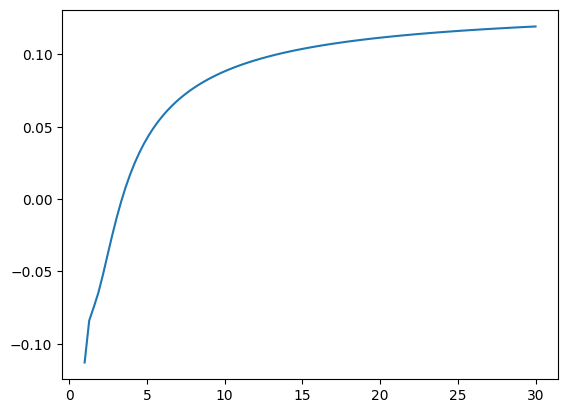

In [ ]:
# Calibración curva NSS ECL
t = np.array(dur_ecl[3:])
y = np.array(irr_ecl[3:])

curve, status = nss_cal.calibrate_nss_ols(t, y, (1,0.5))  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

y = nss.NelsonSiegelSvenssonCurve(curve.beta0, curve.beta1, curve.beta2, curve.beta3, curve.tau1, curve.tau2)
t = np.linspace(1, 30, 100)
plot(t, y(t))

In [ ]:
#pd.DataFrame({'irr':[max(curve.zero(T=i),0) for i in range(1,31)], 'dur':range(1,31)}).to_excel('bin\\curva_irr_ECL.xlsx', index=False)

NelsonSiegelCurve(beta0=np.float64(0.20757466769915828), beta1=np.float64(-0.3806263957939318), beta2=np.float64(-0.15433731028040037), tau=np.float64(1.6690856826260456))


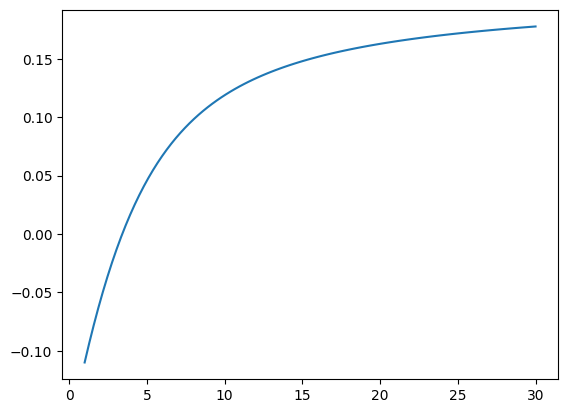

In [ ]:
# Calibración curva NS ECL

t = np.array(dur_ecl[3:])
y = np.array(irr_ecl[3:])

curve, status = ns_cal.calibrate_ns_ols(t, y, tau0=1)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

y = ns.NelsonSiegelCurve(curve.beta0, curve.beta1, curve.beta2, curve.tau)
t = np.linspace(1, 30, 100)
plot(t, y(t))

In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares

In [10]:

# ==========
# 1) Cargar datos
# ==========
path = r"bin\Cartera_bonos 3.xlsx"  # ajustá si hace falta
bonds = pd.read_excel(path, sheet_name="Hoja 1")
cfs   = pd.read_excel(path, sheet_name="Hoja 3")

# Precio de mercado (usar Cotización; es el dirty price en tu tabla)
price = bonds.set_index("Ticker")["Cotización"].astype(float)

# Nos quedamos con los CF "depurados" (según tu hoja 2)
cfs = cfs.rename(columns={
    "Time to Payment": "t",
    "Stochastic Credit Risk Free Cashflow": "cf"})
cfs["t"]  = cfs["t"].astype(float)
cfs["cf"] = cfs["cf"].astype(float)


In [11]:

# ==========
# 2) Nelson–Siegel en tasa zero efectiva anual
#    z(t) = beta0 + beta1 * ((1-exp(-t/tau))/(t/tau)) + beta2 * (((1-exp(-t/tau))/(t/tau)) - exp(-t/tau))
# ==========
def ns_zero_rate(t, beta0, beta1, beta2, tau):
    t = np.asarray(t, dtype=float)
    x = np.maximum(t / tau, 1e-10)  # evitar división por cero
    a = (1 - np.exp(-x)) / x
    return beta0 + beta1 * a + beta2 * (a - np.exp(-x))

def discount_factor(t, params):
    beta0, beta1, beta2, tau = params
    z = ns_zero_rate(t, beta0, beta1, beta2, tau)
    # DF con capitalización efectiva anual:
    return (1.0 / (1.0 + z)) ** t


In [12]:
# ==========
# 3) Función de error (vector de errores por bono)
# ==========
tickers = sorted(cfs["Ticker"].unique())

def residuals(params):
    res = []
    for tk in tickers:
        cf_i = cfs.loc[cfs["Ticker"] == tk, ["t", "cf"]]
        t = cf_i["t"].to_numpy()
        cf = cf_i["cf"].to_numpy()
        pv = np.sum(cf * discount_factor(t, params))
        res.append(pv - float(price.loc[tk]))
    return np.array(res)

In [13]:
# ==========
# 4) Calibración
#    Inicializaciones razonables (ajustables):
# ==========
x0 = np.array([0.05, -0.02, 0.02, 3.0])  # beta0, beta1, beta2, tau

# Restricciones suaves: tau>0; para tasas reales CER pueden ser negativas,
# por eso NO acoto beta0/beta1/beta2 a ser >0.
lb = np.array([-1.0, -2.0, -2.0, 0.05])
ub = np.array([ 2.0,  2.0,  2.0, 50.0])

opt = least_squares(residuals, x0, bounds=(lb, ub))
params_hat = opt.x
print("Params (beta0,beta1,beta2,tau):", params_hat)
print("RMSE precio:", np.sqrt(np.mean(opt.fun**2)))

Params (beta0,beta1,beta2,tau): [-0.42500832 -0.06727282  2.          9.42846498]
RMSE precio: 233.42739074579217


In [14]:
# ==========
# 5) Curva zero en tus fechas objetivo (en años)
#    Vos pedís 30/6 de cada año. Si querés exactitud ACT/365 desde 28-Jun-24,
#    calculás t exacto con fechas; acá muestro nodos anuales aproximados:
# ==========
target_years = np.arange(1, 31, 1)  # 1..21 años (2025..2045 aprox)
z_targets = ns_zero_rate(target_years, *params_hat)
df_targets = discount_factor(target_years, params_hat)

curve = pd.DataFrame({
    "t_years": target_years,
    "zero_rate_eff_annual": z_targets,
    "discount_factor": df_targets
})
print(curve)
curve.to_excel(r"bin\curva_zero_ns_2.xlsx", index=False)


    t_years  zero_rate_eff_annual  discount_factor
0         1             -0.389984         1.639301
1         2             -0.301242         2.048077
2         3             -0.224525         2.144355
3         4             -0.158467         1.993959
4         5             -0.101850         1.711024
5         6             -0.053586         1.391593
6         7             -0.012704         1.093626
7         8              0.021659         0.842465
8         9              0.050275         0.643093
9        10              0.073829         0.490511
10       11              0.092933         0.376246
11       12              0.108130         0.291683
12       13              0.119904         0.229430
13       14              0.128685         0.183647
14       15              0.134854         0.149935
15       16              0.138750         0.125068
16       17              0.140674         0.106722
17       18              0.140892         0.093239
18       19              0.1396

In [32]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

# =========================
# 0) Cargar Excel
# =========================
path = r"bin\Cartera_bonos 3.xlsx"  # ajustá ruta si hace falta

bonds = pd.read_excel(path, sheet_name="Hoja 1")
cfs   = pd.read_excel(path, sheet_name="Hoja 2")

# -------------------------
# Chequeos mínimos
# -------------------------
required_bonds_cols = {"Ticker", "Cotización", "Fecha cot."}
required_cfs_cols   = {"Ticker", "Time to Payment", "Stochastic Credit Risk Free Cashflow"}

missing_bonds = required_bonds_cols - set(bonds.columns)
missing_cfs   = required_cfs_cols   - set(cfs.columns)

if missing_bonds:
    raise ValueError(f"Faltan columnas en Hoja 1: {missing_bonds}")
if missing_cfs:
    raise ValueError(f"Faltan columnas en Hoja 2: {missing_cfs}")

# Precio objetivo por bono (dirty price)
price = (bonds[["Ticker", "Dirty Price"]]
         .dropna()
         .set_index("Ticker")["Dirty Price"]
         .astype(float))

# Cashflows
cf_tbl = cfs.rename(columns={
    "Time to Payment": "t",
    "Stochastic Credit Risk Free Cashflow": "cf"
}).copy()

cf_tbl["t"]  = cf_tbl["t"].astype(float)
cf_tbl["cf"] = cf_tbl["cf"].astype(float)

tickers = sorted(set(cf_tbl["Ticker"].unique()) & set(price.index))
if not tickers:
    raise ValueError("No hay tickers en común entre Hoja 1 y Hoja 2.")

# =========================
# 1) Nelson–Siegel–Svensson
#    y(t) (tasa zero, cont. comp.) en función de:
#    beta0,beta1,beta2,beta3,tau1,tau2
# =========================
def _ns_loading(t, tau):
    """(1-exp(-t/tau))/(t/tau) con manejo t→0."""
    t = np.asarray(t, dtype=float)
    x = np.maximum(t / tau, 1e-10)
    return (1.0 - np.exp(-x)) / x

def nss_zero_rate(t, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    NSS (Svensson):
    y(t)=β0 + β1*L1 + β2*(L1-exp(-t/tau1)) + β3*(L2-exp(-t/tau2))
    """
    t = np.asarray(t, dtype=float)
    L1 = _ns_loading(t, tau1)
    L2 = _ns_loading(t, tau2)
    term1 = L1
    term2 = (L1 - np.exp(-np.maximum(t / tau1, 1e-10)))
    term3 = (L2 - np.exp(-np.maximum(t / tau2, 1e-10)))
    return beta0 + beta1*term1 + beta2*term2 + beta3*term3

def discount_factor_continuous(t, params):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    y = nss_zero_rate(t, beta0, beta1, beta2, beta3, tau1, tau2)
    return np.exp(-y * np.asarray(t, dtype=float))

# =========================
# 2) PV por bono y residuales
# =========================
def model_price_for_ticker(tk, params):
    sub = cf_tbl.loc[cf_tbl["Ticker"] == tk, ["t", "cf"]]
    t = sub["t"].to_numpy()
    cf = sub["cf"].to_numpy()
    df = discount_factor_continuous(t, params)
    return np.sum(cf * df)

# Pesos: para homogeneizar, es común ponderar por 1/Precio o 1/Duración.
# Acá uso 1/Precio (simple y estable).
weights = {tk: 1.0 / max(float(price.loc[tk]), 1e-8) for tk in tickers}

def residuals(params):
    res = []
    for tk in tickers:
        pv = model_price_for_ticker(tk, params)
        err = (pv - float(price.loc[tk])) * weights[tk]
        res.append(err)
    return np.array(res)

# =========================
# 3) Calibración
# =========================
# Inicial razonable (ajustá si querés):
x0 = np.array([0.05, -0.02, 0.02, 0.01, 2.0, 10.0])  # β0 β1 β2 β3 τ1 τ2

# Bounds: tasas reales podrían ser negativas, pero acotamos por estabilidad.
lb = np.array([-1.0, -3.0, -3.0, -3.0, 0.05, 0.05])
ub = np.array([ 2.0,  3.0,  3.0,  3.0, 50.0, 50.0])

opt = least_squares(residuals, x0, bounds=(lb, ub))
params_hat = opt.x

print("=== NSS calibrado ===")
print("beta0, beta1, beta2, beta3, tau1, tau2 =", params_hat)
print("RMSE (error relativo aprox, por ponderación 1/Precio) =", np.sqrt(np.mean(opt.fun**2)))

# Error por bono (en precio, no ponderado)
print("\n=== Errores por bono (precio) ===")
for tk in tickers:
    pv = model_price_for_ticker(tk, params_hat)
    print(f"{tk:6s}  P_mkt={float(price.loc[tk]):12.4f}  P_model={pv:12.4f}  diff={pv-float(price.loc[tk]): .4f}")

# =========================
# 4) Curva en tus fechas 30-Jun (2025–2045)
#    Usamos ACT/365F desde Fecha cot. (28-Jun-24 en tu archivo)
# =========================
val_date = pd.to_datetime(bonds["Fecha cot."].dropna().iloc[0])

target_dates = pd.to_datetime([f"{y}-06-30" for y in range(2025, 2046)])
t_targets = (target_dates - val_date).days / 365.0

y_targets = nss_zero_rate(t_targets, *params_hat)
df_targets = np.exp(-y_targets * t_targets)

# Si querés tasa efectiva anual equivalente:
eff_targets = np.exp(y_targets) - 1.0  # porque y es cont. comp. anual

curve = pd.DataFrame({
    "date": target_dates,
    "t_years_ACT365": t_targets,
    "zero_rate_cont": y_targets,
    "zero_rate_eff": eff_targets,
    "discount_factor": df_targets
})

print("\n=== Curva NSS en 30-Jun (2025–2045) ===")
print(curve.to_string(index=False))
curve.to_excel(r"bin\curva_zero_nss_2.xlsx", index=False)


=== NSS calibrado ===
beta0, beta1, beta2, beta3, tau1, tau2 = [ 0.19238793 -0.48852147 -2.36788229  2.99999999  2.27772917  1.04175818]
RMSE (error relativo aprox, por ponderación 1/Precio) = 0.24489604990928643

=== Errores por bono (precio) ===
CUAP    P_mkt=  38606.0800  P_model=  36739.7600  diff=-1866.3200
DICP    P_mkt=  33544.1600  P_model=  29621.7345  diff=-3922.4255
PARP    P_mkt=  27924.1300  P_model=  30974.1122  diff= 3049.9822
TZX25   P_mkt=    100.0000  P_model=    111.3164  diff= 11.3164
TZX26   P_mkt=    100.0000  P_model=    114.1932  diff= 14.1932
TZX27   P_mkt=    100.0000  P_model=    135.5156  diff= 35.5156
TZX28   P_mkt=    201.8700  P_model=    184.0562  diff=-17.8138
TZXD5   P_mkt=    150.0600  P_model=     85.8249  diff=-64.2351
TZXD6   P_mkt=    149.2400  P_model=     87.4347  diff=-61.8053
TZXD7   P_mkt=    149.2400  P_model=    115.8080  diff=-33.4320

=== Curva NSS en 30-Jun (2025–2045) ===
      date  t_years_ACT365  zero_rate_cont  zero_rate_eff  discou